<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/tuned_cnn_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [2]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=46da9fda2fbf58dab152c6ba2c1d2d551a4b378966cb9f55f84b9c2c931c1efb
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=e695ed86a3192b0dd1b05d609cccc7eb7c9913dad904a2d83a6e6162c42bc0f3
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

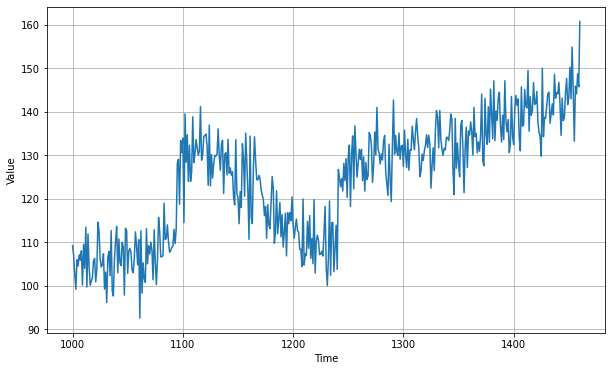

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding='causal', activation='relu', input_shape=[None, 1]))
  
  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(momentum=0.5, lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Epoch 1/100
31/31 - 7s - loss: 680.3195
Epoch 2/100
31/31 - 0s - loss: 85.7052
Epoch 3/100
31/31 - 0s - loss: 68.7535
Epoch 4/100
31/31 - 0s - loss: 67.4663
Epoch 5/100
31/31 - 0s - loss: 66.9186
Epoch 6/100
31/31 - 0s - loss: 67.5778
Epoch 7/100
31/31 - 0s - loss: 67.6968
Epoch 8/100
31/31 - 0s - loss: 67.6549
Epoch 9/100
31/31 - 0s - loss: 67.3424
Epoch 10/100
31/31 - 0s - loss: 66.1925
Epoch 11/100
31/31 - 0s - loss: 66.3565
Epoch 12/100
31/31 - 0s - loss: 66.5883
Epoch 13/100
31/31 - 0s - loss: 65.4137
Epoch 14/100
31/31 - 0s - loss: 66.3699
Epoch 15/100
31/31 - 0s - loss: 66.4552
Epoch 16/100
31/31 - 0s - loss: 66.5398
Epoch 17/100
31/31 - 0s - loss: 65.9640
Epoch 18/100
31/31 - 0s - loss: 66.2945
Epoch 19/100
31/31 - 0s - loss: 66.4943
Epoch 20/100
31/31 - 0s - loss: 66.3353
Epoch 21/100
31/31 - 0s - loss: 65.7544
Epoch 22/100
31/31 - 0s - loss: 66.9778
Epoch 23/100
31/31 - 0s - loss: 65.6247
Epoch 24/100
31/31 - 0s - loss: 64.8101
Epoch 25/100
31/31 - 0s - loss: 65.3802
Epoch 26

Epoch 1/100
31/31 - 1s - loss: 651.9336
Epoch 2/100
31/31 - 0s - loss: 109.3723
Epoch 3/100
31/31 - 0s - loss: 71.9962
Epoch 4/100
31/31 - 0s - loss: 67.4002
Epoch 5/100
31/31 - 0s - loss: 66.0863
Epoch 6/100
31/31 - 0s - loss: 66.9164
Epoch 7/100
31/31 - 0s - loss: 66.6153
Epoch 8/100
31/31 - 0s - loss: 66.9041
Epoch 9/100
31/31 - 0s - loss: 65.6754
Epoch 10/100
31/31 - 0s - loss: 66.0891
Epoch 11/100
31/31 - 0s - loss: 66.4577
Epoch 12/100
31/31 - 0s - loss: 66.2586
Epoch 13/100
31/31 - 0s - loss: 65.4329
Epoch 14/100
31/31 - 0s - loss: 65.8155
Epoch 15/100
31/31 - 0s - loss: 65.6809
Epoch 16/100
31/31 - 0s - loss: 65.1899
Epoch 17/100
31/31 - 0s - loss: 66.4966
Epoch 18/100
31/31 - 0s - loss: 65.3443
Epoch 19/100
31/31 - 0s - loss: 65.1531
Epoch 20/100
31/31 - 0s - loss: 65.6636
Epoch 21/100
31/31 - 0s - loss: 65.3946
Epoch 22/100
31/31 - 0s - loss: 65.1975
Epoch 23/100
31/31 - 0s - loss: 65.4493
Epoch 24/100
31/31 - 0s - loss: 65.1340
Epoch 25/100
31/31 - 0s - loss: 64.9696
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 859.5166
Epoch 2/100
31/31 - 0s - loss: 144.5122
Epoch 3/100
31/31 - 0s - loss: 92.7237
Epoch 4/100
31/31 - 0s - loss: 75.3720
Epoch 5/100
31/31 - 0s - loss: 70.6806
Epoch 6/100
31/31 - 0s - loss: 67.8428
Epoch 7/100
31/31 - 0s - loss: 68.2167
Epoch 8/100
31/31 - 0s - loss: 67.4189
Epoch 9/100
31/31 - 0s - loss: 67.7328
Epoch 10/100
31/31 - 0s - loss: 66.7079
Epoch 11/100
31/31 - 0s - loss: 65.3741
Epoch 12/100
31/31 - 0s - loss: 67.1905
Epoch 13/100
31/31 - 0s - loss: 65.9147
Epoch 14/100
31/31 - 0s - loss: 66.6741
Epoch 15/100
31/31 - 0s - loss: 65.7176
Epoch 16/100
31/31 - 0s - loss: 65.4213
Epoch 17/100
31/31 - 0s - loss: 65.8888
Epoch 18/100
31/31 - 0s - loss: 65.6131
Epoch 19/100
31/31 - 0s - loss: 65.8350
Epoch 20/100
31/31 - 0s - loss: 67.0025
Epoch 21/100
31/31 - 0s - loss: 66.2005
Epoch 22/100
31/31 - 0s - loss: 65.5504
Epoch 23/100
31/31 - 0s - loss: 65.3076
Epoch 24/100
31/31 - 0s - loss: 65.4895
Epoch 25/100
31/31 - 0s - loss: 66.0843
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 644.6419
Epoch 2/100
31/31 - 0s - loss: 132.5290
Epoch 3/100
31/31 - 0s - loss: 74.8106
Epoch 4/100
31/31 - 0s - loss: 68.5269
Epoch 5/100
31/31 - 0s - loss: 68.4451
Epoch 6/100
31/31 - 0s - loss: 67.7748
Epoch 7/100
31/31 - 0s - loss: 67.4497
Epoch 8/100
31/31 - 0s - loss: 67.1554
Epoch 9/100
31/31 - 0s - loss: 66.7048
Epoch 10/100
31/31 - 0s - loss: 66.7681
Epoch 11/100
31/31 - 0s - loss: 66.1994
Epoch 12/100
31/31 - 0s - loss: 66.0678
Epoch 13/100
31/31 - 0s - loss: 65.9580
Epoch 14/100
31/31 - 0s - loss: 68.2869
Epoch 15/100
31/31 - 0s - loss: 65.5666
Epoch 16/100
31/31 - 0s - loss: 66.4042
Epoch 17/100
31/31 - 0s - loss: 66.2361
Epoch 18/100
31/31 - 0s - loss: 64.7507
Epoch 19/100
31/31 - 0s - loss: 65.2987
Epoch 20/100
31/31 - 0s - loss: 66.3748
Epoch 21/100
31/31 - 0s - loss: 65.6605
Epoch 22/100
31/31 - 0s - loss: 65.9108
Epoch 23/100
31/31 - 0s - loss: 65.3768
Epoch 24/100
31/31 - 0s - loss: 65.8692
Epoch 25/100
31/31 - 0s - loss: 64.7627
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 480.8100
Epoch 2/100
31/31 - 0s - loss: 92.5033
Epoch 3/100
31/31 - 0s - loss: 73.5200
Epoch 4/100
31/31 - 0s - loss: 71.5772
Epoch 5/100
31/31 - 0s - loss: 71.2194
Epoch 6/100
31/31 - 0s - loss: 71.2971
Epoch 7/100
31/31 - 0s - loss: 70.5150
Epoch 8/100
31/31 - 0s - loss: 69.8371
Epoch 9/100
31/31 - 0s - loss: 69.5966
Epoch 10/100
31/31 - 0s - loss: 69.7793
Epoch 11/100
31/31 - 0s - loss: 69.7022
Epoch 12/100
31/31 - 0s - loss: 68.9566
Epoch 13/100
31/31 - 0s - loss: 68.6271
Epoch 14/100
31/31 - 0s - loss: 68.5236
Epoch 15/100
31/31 - 0s - loss: 69.4225
Epoch 16/100
31/31 - 0s - loss: 69.4833
Epoch 17/100
31/31 - 0s - loss: 68.8020
Epoch 18/100
31/31 - 0s - loss: 67.8568
Epoch 19/100
31/31 - 0s - loss: 69.0827
Epoch 20/100
31/31 - 0s - loss: 67.6403
Epoch 21/100
31/31 - 0s - loss: 68.6952
Epoch 22/100
31/31 - 0s - loss: 68.1472
Epoch 23/100
31/31 - 0s - loss: 67.0994
Epoch 24/100
31/31 - 0s - loss: 68.1821
Epoch 25/100
31/31 - 0s - loss: 68.6510
Epoch 26

Epoch 1/100
31/31 - 1s - loss: 451.0578
Epoch 2/100
31/31 - 0s - loss: 106.8843
Epoch 3/100
31/31 - 0s - loss: 85.5931
Epoch 4/100
31/31 - 0s - loss: 75.2406
Epoch 5/100
31/31 - 0s - loss: 71.7809
Epoch 6/100
31/31 - 0s - loss: 68.7983
Epoch 7/100
31/31 - 0s - loss: 67.8041
Epoch 8/100
31/31 - 0s - loss: 68.2086
Epoch 9/100
31/31 - 0s - loss: 66.8332
Epoch 10/100
31/31 - 0s - loss: 66.4112
Epoch 11/100
31/31 - 0s - loss: 66.5469
Epoch 12/100
31/31 - 0s - loss: 65.9689
Epoch 13/100
31/31 - 0s - loss: 66.2552
Epoch 14/100
31/31 - 0s - loss: 66.4116
Epoch 15/100
31/31 - 0s - loss: 65.8402
Epoch 16/100
31/31 - 0s - loss: 65.9469
Epoch 17/100
31/31 - 0s - loss: 66.0419
Epoch 18/100
31/31 - 0s - loss: 65.6998
Epoch 19/100
31/31 - 0s - loss: 64.7592
Epoch 20/100
31/31 - 0s - loss: 65.3358
Epoch 21/100
31/31 - 0s - loss: 65.7745
Epoch 22/100
31/31 - 0s - loss: 65.8396
Epoch 23/100
31/31 - 0s - loss: 64.4411
Epoch 24/100
31/31 - 0s - loss: 64.6464
Epoch 25/100
31/31 - 0s - loss: 63.8069
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 556.3923
Epoch 2/100
31/31 - 0s - loss: 127.1134
Epoch 3/100
31/31 - 0s - loss: 81.9768
Epoch 4/100
31/31 - 0s - loss: 72.3384
Epoch 5/100
31/31 - 0s - loss: 69.2962
Epoch 6/100
31/31 - 0s - loss: 67.6131
Epoch 7/100
31/31 - 0s - loss: 66.4224
Epoch 8/100
31/31 - 0s - loss: 66.0281
Epoch 9/100
31/31 - 0s - loss: 65.5870
Epoch 10/100
31/31 - 0s - loss: 66.2432
Epoch 11/100
31/31 - 0s - loss: 65.8380
Epoch 12/100
31/31 - 0s - loss: 66.4492
Epoch 13/100
31/31 - 0s - loss: 64.9332
Epoch 14/100
31/31 - 0s - loss: 65.7550
Epoch 15/100
31/31 - 0s - loss: 65.5445
Epoch 16/100
31/31 - 0s - loss: 64.6934
Epoch 17/100
31/31 - 0s - loss: 64.8387
Epoch 18/100
31/31 - 0s - loss: 65.4967
Epoch 19/100
31/31 - 0s - loss: 64.5176
Epoch 20/100
31/31 - 0s - loss: 65.6384
Epoch 21/100
31/31 - 0s - loss: 65.5364
Epoch 22/100
31/31 - 0s - loss: 63.9206
Epoch 23/100
31/31 - 0s - loss: 65.3330
Epoch 24/100
31/31 - 0s - loss: 65.4129
Epoch 25/100
31/31 - 0s - loss: 64.5525
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 595.9434
Epoch 2/100
31/31 - 0s - loss: 124.0839
Epoch 3/100
31/31 - 0s - loss: 100.5885
Epoch 4/100
31/31 - 0s - loss: 87.8321
Epoch 5/100
31/31 - 0s - loss: 79.0122
Epoch 6/100
31/31 - 0s - loss: 76.3098
Epoch 7/100
31/31 - 0s - loss: 72.9976
Epoch 8/100
31/31 - 0s - loss: 72.1296
Epoch 9/100
31/31 - 0s - loss: 71.8641
Epoch 10/100
31/31 - 0s - loss: 70.7070
Epoch 11/100
31/31 - 0s - loss: 70.2594
Epoch 12/100
31/31 - 0s - loss: 70.5038
Epoch 13/100
31/31 - 0s - loss: 69.5839
Epoch 14/100
31/31 - 0s - loss: 69.5888
Epoch 15/100
31/31 - 0s - loss: 69.0288
Epoch 16/100
31/31 - 0s - loss: 68.5799
Epoch 17/100
31/31 - 0s - loss: 69.0815
Epoch 18/100
31/31 - 0s - loss: 68.1580
Epoch 19/100
31/31 - 0s - loss: 68.0739
Epoch 20/100
31/31 - 0s - loss: 66.8539
Epoch 21/100
31/31 - 0s - loss: 67.2131
Epoch 22/100
31/31 - 0s - loss: 67.2331
Epoch 23/100
31/31 - 0s - loss: 68.2432
Epoch 24/100
31/31 - 0s - loss: 66.3837
Epoch 25/100
31/31 - 0s - loss: 66.2524
Epoch 

Epoch 1/100
31/31 - 1s - loss: 366.0655
Epoch 2/100
31/31 - 0s - loss: 81.3018
Epoch 3/100
31/31 - 0s - loss: 67.9748
Epoch 4/100
31/31 - 0s - loss: 66.5225
Epoch 5/100
31/31 - 0s - loss: 67.2098
Epoch 6/100
31/31 - 0s - loss: 66.3673
Epoch 7/100
31/31 - 0s - loss: 66.4603
Epoch 8/100
31/31 - 0s - loss: 66.5957
Epoch 9/100
31/31 - 0s - loss: 66.2761
Epoch 10/100
31/31 - 0s - loss: 64.0845
Epoch 11/100
31/31 - 0s - loss: 65.1818
Epoch 12/100
31/31 - 0s - loss: 65.5496
Epoch 13/100
31/31 - 0s - loss: 64.3853
Epoch 14/100
31/31 - 0s - loss: 64.2524
Epoch 15/100
31/31 - 0s - loss: 64.5707
Epoch 16/100
31/31 - 0s - loss: 63.7056
Epoch 17/100
31/31 - 0s - loss: 64.0681
Epoch 18/100
31/31 - 0s - loss: 64.8331
Epoch 19/100
31/31 - 0s - loss: 64.1513
Epoch 20/100
31/31 - 0s - loss: 64.5687
Epoch 21/100
31/31 - 0s - loss: 65.8030
Epoch 22/100
31/31 - 0s - loss: 62.7601
Epoch 23/100
31/31 - 0s - loss: 63.3960
Epoch 24/100
31/31 - 0s - loss: 63.9391
Epoch 25/100
31/31 - 0s - loss: 63.5033
Epoch 26

Epoch 1/100
31/31 - 1s - loss: 1099.1983
Epoch 2/100
31/31 - 0s - loss: 125.6670
Epoch 3/100
31/31 - 0s - loss: 90.9794
Epoch 4/100
31/31 - 0s - loss: 76.1384
Epoch 5/100
31/31 - 0s - loss: 71.5628
Epoch 6/100
31/31 - 0s - loss: 70.5075
Epoch 7/100
31/31 - 0s - loss: 69.9051
Epoch 8/100
31/31 - 0s - loss: 69.3672
Epoch 9/100
31/31 - 0s - loss: 69.1509
Epoch 10/100
31/31 - 0s - loss: 69.0646
Epoch 11/100
31/31 - 0s - loss: 69.2722
Epoch 12/100
31/31 - 0s - loss: 68.5249
Epoch 13/100
31/31 - 0s - loss: 67.8810
Epoch 14/100
31/31 - 0s - loss: 69.2176
Epoch 15/100
31/31 - 0s - loss: 69.2618
Epoch 16/100
31/31 - 0s - loss: 69.1780
Epoch 17/100
31/31 - 0s - loss: 67.5026
Epoch 18/100
31/31 - 0s - loss: 67.7284
Epoch 19/100
31/31 - 0s - loss: 67.0440
Epoch 20/100
31/31 - 0s - loss: 68.1313
Epoch 21/100
31/31 - 0s - loss: 66.4832
Epoch 22/100
31/31 - 0s - loss: 66.5278
Epoch 23/100
31/31 - 0s - loss: 66.6196
Epoch 24/100
31/31 - 0s - loss: 66.8323
Epoch 25/100
31/31 - 0s - loss: 66.0860
Epoch 

Epoch 1/100
31/31 - 1s - loss: 947.5813
Epoch 2/100
31/31 - 0s - loss: 144.6986
Epoch 3/100
31/31 - 0s - loss: 78.0199
Epoch 4/100
31/31 - 0s - loss: 70.6856
Epoch 5/100
31/31 - 0s - loss: 70.4158
Epoch 6/100
31/31 - 0s - loss: 69.0455
Epoch 7/100
31/31 - 0s - loss: 67.9388
Epoch 8/100
31/31 - 0s - loss: 67.6335
Epoch 9/100
31/31 - 0s - loss: 67.7281
Epoch 10/100
31/31 - 0s - loss: 67.1096
Epoch 11/100
31/31 - 0s - loss: 67.5717
Epoch 12/100
31/31 - 0s - loss: 66.3164
Epoch 13/100
31/31 - 0s - loss: 67.7976
Epoch 14/100
31/31 - 0s - loss: 67.2974
Epoch 15/100
31/31 - 0s - loss: 67.8005
Epoch 16/100
31/31 - 0s - loss: 67.2372
Epoch 17/100
31/31 - 0s - loss: 65.4027
Epoch 18/100
31/31 - 0s - loss: 67.8854
Epoch 19/100
31/31 - 0s - loss: 66.9977
Epoch 20/100
31/31 - 0s - loss: 65.7077
Epoch 21/100
31/31 - 0s - loss: 65.6576
Epoch 22/100
31/31 - 0s - loss: 67.3457
Epoch 23/100
31/31 - 0s - loss: 66.4292
Epoch 24/100
31/31 - 0s - loss: 66.1632
Epoch 25/100
31/31 - 0s - loss: 65.9446
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 663.5867
Epoch 2/100
31/31 - 0s - loss: 114.1362
Epoch 3/100
31/31 - 0s - loss: 79.0238
Epoch 4/100
31/31 - 0s - loss: 71.2082
Epoch 5/100
31/31 - 0s - loss: 70.1000
Epoch 6/100
31/31 - 0s - loss: 69.2875
Epoch 7/100
31/31 - 0s - loss: 69.0587
Epoch 8/100
31/31 - 0s - loss: 68.2022
Epoch 9/100
31/31 - 0s - loss: 69.2052
Epoch 10/100
31/31 - 0s - loss: 69.2279
Epoch 11/100
31/31 - 0s - loss: 67.6915
Epoch 12/100
31/31 - 0s - loss: 67.3384
Epoch 13/100
31/31 - 0s - loss: 66.9881
Epoch 14/100
31/31 - 0s - loss: 67.3831
Epoch 15/100
31/31 - 0s - loss: 66.5732
Epoch 16/100
31/31 - 0s - loss: 67.6648
Epoch 17/100
31/31 - 0s - loss: 67.2600
Epoch 18/100
31/31 - 0s - loss: 67.0906
Epoch 19/100
31/31 - 0s - loss: 67.0972
Epoch 20/100
31/31 - 0s - loss: 65.9073
Epoch 21/100
31/31 - 0s - loss: 66.1762
Epoch 22/100
31/31 - 0s - loss: 65.5625
Epoch 23/100
31/31 - 0s - loss: 65.7152
Epoch 24/100
31/31 - 0s - loss: 66.4772
Epoch 25/100
31/31 - 0s - loss: 65.5998
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 542.7453
Epoch 2/100
31/31 - 0s - loss: 112.0247
Epoch 3/100
31/31 - 0s - loss: 85.4097
Epoch 4/100
31/31 - 0s - loss: 75.2897
Epoch 5/100
31/31 - 0s - loss: 70.2136
Epoch 6/100
31/31 - 0s - loss: 67.7514
Epoch 7/100
31/31 - 0s - loss: 67.2977
Epoch 8/100
31/31 - 0s - loss: 66.3586
Epoch 9/100
31/31 - 0s - loss: 64.9667
Epoch 10/100
31/31 - 0s - loss: 63.9908
Epoch 11/100
31/31 - 0s - loss: 65.0350
Epoch 12/100
31/31 - 0s - loss: 64.2949
Epoch 13/100
31/31 - 0s - loss: 63.0447
Epoch 14/100
31/31 - 0s - loss: 63.5583
Epoch 15/100
31/31 - 0s - loss: 63.3101
Epoch 16/100
31/31 - 0s - loss: 62.4940
Epoch 17/100
31/31 - 0s - loss: 63.3171
Epoch 18/100
31/31 - 0s - loss: 64.1626
Epoch 19/100
31/31 - 0s - loss: 63.3580
Epoch 20/100
31/31 - 0s - loss: 64.2833
Epoch 21/100
31/31 - 0s - loss: 62.6585
Epoch 22/100
31/31 - 0s - loss: 62.6518
Epoch 23/100
31/31 - 0s - loss: 62.2806
Epoch 24/100
31/31 - 0s - loss: 62.4114
Epoch 25/100
31/31 - 0s - loss: 62.0712
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 631.6465
Epoch 2/100
31/31 - 0s - loss: 140.0041
Epoch 3/100
31/31 - 0s - loss: 89.6300
Epoch 4/100
31/31 - 0s - loss: 72.7768
Epoch 5/100
31/31 - 0s - loss: 68.7811
Epoch 6/100
31/31 - 0s - loss: 66.5995
Epoch 7/100
31/31 - 0s - loss: 65.4071
Epoch 8/100
31/31 - 0s - loss: 66.2080
Epoch 9/100
31/31 - 0s - loss: 65.1959
Epoch 10/100
31/31 - 0s - loss: 65.8391
Epoch 11/100
31/31 - 0s - loss: 66.8592
Epoch 12/100
31/31 - 0s - loss: 64.9484
Epoch 13/100
31/31 - 0s - loss: 64.4522
Epoch 14/100
31/31 - 0s - loss: 65.6253
Epoch 15/100
31/31 - 0s - loss: 65.5800
Epoch 16/100
31/31 - 0s - loss: 65.2897
Epoch 17/100
31/31 - 0s - loss: 64.7235
Epoch 18/100
31/31 - 0s - loss: 64.6153
Epoch 19/100
31/31 - 0s - loss: 64.4531
Epoch 20/100
31/31 - 0s - loss: 64.0729
Epoch 21/100
31/31 - 0s - loss: 64.3805
Epoch 22/100
31/31 - 0s - loss: 63.8943
Epoch 23/100
31/31 - 0s - loss: 64.2676
Epoch 24/100
31/31 - 0s - loss: 63.5381
Epoch 25/100
31/31 - 0s - loss: 64.4999
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 436.6479
Epoch 2/100
31/31 - 0s - loss: 103.0579
Epoch 3/100
31/31 - 0s - loss: 76.6042
Epoch 4/100
31/31 - 0s - loss: 71.4386
Epoch 5/100
31/31 - 0s - loss: 70.0057
Epoch 6/100
31/31 - 0s - loss: 70.1768
Epoch 7/100
31/31 - 0s - loss: 68.6046
Epoch 8/100
31/31 - 0s - loss: 68.0048
Epoch 9/100
31/31 - 0s - loss: 67.5096
Epoch 10/100
31/31 - 0s - loss: 67.3972
Epoch 11/100
31/31 - 0s - loss: 66.7451
Epoch 12/100
31/31 - 0s - loss: 67.3425
Epoch 13/100
31/31 - 0s - loss: 66.4910
Epoch 14/100
31/31 - 0s - loss: 66.0361
Epoch 15/100
31/31 - 0s - loss: 65.9053
Epoch 16/100
31/31 - 0s - loss: 67.6127
Epoch 17/100
31/31 - 0s - loss: 65.8036
Epoch 18/100
31/31 - 0s - loss: 65.3974
Epoch 19/100
31/31 - 0s - loss: 65.5036
Epoch 20/100
31/31 - 0s - loss: 65.9931
Epoch 21/100
31/31 - 0s - loss: 66.3576
Epoch 22/100
31/31 - 0s - loss: 65.6311
Epoch 23/100
31/31 - 0s - loss: 65.3866
Epoch 24/100
31/31 - 0s - loss: 65.5408
Epoch 25/100
31/31 - 0s - loss: 63.6743
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 401.6008
Epoch 2/100
31/31 - 0s - loss: 81.7709
Epoch 3/100
31/31 - 0s - loss: 68.7087
Epoch 4/100
31/31 - 0s - loss: 67.4065
Epoch 5/100
31/31 - 0s - loss: 68.4699
Epoch 6/100
31/31 - 0s - loss: 67.7892
Epoch 7/100
31/31 - 0s - loss: 68.1599
Epoch 8/100
31/31 - 0s - loss: 67.7760
Epoch 9/100
31/31 - 0s - loss: 68.1852
Epoch 10/100
31/31 - 0s - loss: 66.5564
Epoch 11/100
31/31 - 0s - loss: 65.9005
Epoch 12/100
31/31 - 0s - loss: 67.4271
Epoch 13/100
31/31 - 0s - loss: 67.8686
Epoch 14/100
31/31 - 0s - loss: 65.4857
Epoch 15/100
31/31 - 0s - loss: 65.4028
Epoch 16/100
31/31 - 0s - loss: 65.2181
Epoch 17/100
31/31 - 0s - loss: 66.9538
Epoch 18/100
31/31 - 0s - loss: 65.1101
Epoch 19/100
31/31 - 0s - loss: 65.1893
Epoch 20/100
31/31 - 0s - loss: 64.7934
Epoch 21/100
31/31 - 0s - loss: 68.0371
Epoch 22/100
31/31 - 0s - loss: 65.2043
Epoch 23/100
31/31 - 0s - loss: 65.7914
Epoch 24/100
31/31 - 0s - loss: 65.6350
Epoch 25/100
31/31 - 0s - loss: 66.4179
Epoch 26

Epoch 1/100
31/31 - 1s - loss: 992.7085
Epoch 2/100
31/31 - 0s - loss: 167.9384
Epoch 3/100
31/31 - 0s - loss: 91.0589
Epoch 4/100
31/31 - 0s - loss: 74.7884
Epoch 5/100
31/31 - 0s - loss: 69.8442
Epoch 6/100
31/31 - 0s - loss: 68.6436
Epoch 7/100
31/31 - 0s - loss: 68.3743
Epoch 8/100
31/31 - 0s - loss: 67.4120
Epoch 9/100
31/31 - 0s - loss: 66.2036
Epoch 10/100
31/31 - 0s - loss: 66.6065
Epoch 11/100
31/31 - 0s - loss: 67.7325
Epoch 12/100
31/31 - 0s - loss: 67.1930
Epoch 13/100
31/31 - 0s - loss: 67.3917
Epoch 14/100
31/31 - 0s - loss: 66.0533
Epoch 15/100
31/31 - 0s - loss: 66.0501
Epoch 16/100
31/31 - 0s - loss: 65.9889
Epoch 17/100
31/31 - 0s - loss: 66.1358
Epoch 18/100
31/31 - 0s - loss: 65.2621
Epoch 19/100
31/31 - 0s - loss: 65.5447
Epoch 20/100
31/31 - 0s - loss: 65.4467
Epoch 21/100
31/31 - 0s - loss: 65.4022
Epoch 22/100
31/31 - 0s - loss: 65.1746
Epoch 23/100
31/31 - 0s - loss: 64.8737
Epoch 24/100
31/31 - 0s - loss: 65.8870
Epoch 25/100
31/31 - 0s - loss: 65.3661
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 550.7377
Epoch 2/100
31/31 - 0s - loss: 87.3662
Epoch 3/100
31/31 - 0s - loss: 71.4464
Epoch 4/100
31/31 - 0s - loss: 69.4374
Epoch 5/100
31/31 - 0s - loss: 68.5556
Epoch 6/100
31/31 - 0s - loss: 68.2926
Epoch 7/100
31/31 - 0s - loss: 69.0070
Epoch 8/100
31/31 - 0s - loss: 67.0190
Epoch 9/100
31/31 - 0s - loss: 66.9424
Epoch 10/100
31/31 - 0s - loss: 66.2138
Epoch 11/100
31/31 - 0s - loss: 66.6756
Epoch 12/100
31/31 - 0s - loss: 66.6098
Epoch 13/100
31/31 - 0s - loss: 66.0288
Epoch 14/100
31/31 - 0s - loss: 66.5074
Epoch 15/100
31/31 - 0s - loss: 65.5290
Epoch 16/100
31/31 - 0s - loss: 66.0553
Epoch 17/100
31/31 - 0s - loss: 65.8431
Epoch 18/100
31/31 - 0s - loss: 66.3610
Epoch 19/100
31/31 - 0s - loss: 65.6175
Epoch 20/100
31/31 - 0s - loss: 66.0494
Epoch 21/100
31/31 - 0s - loss: 65.4900
Epoch 22/100
31/31 - 0s - loss: 66.9078
Epoch 23/100
31/31 - 0s - loss: 65.6037
Epoch 24/100
31/31 - 0s - loss: 66.0073
Epoch 25/100
31/31 - 0s - loss: 64.9980
Epoch 26

Epoch 1/100
31/31 - 1s - loss: 618.6173
Epoch 2/100
31/31 - 0s - loss: 119.2934
Epoch 3/100
31/31 - 0s - loss: 80.5519
Epoch 4/100
31/31 - 0s - loss: 70.0443
Epoch 5/100
31/31 - 0s - loss: 68.2031
Epoch 6/100
31/31 - 0s - loss: 67.1011
Epoch 7/100
31/31 - 0s - loss: 67.5836
Epoch 8/100
31/31 - 0s - loss: 66.5555
Epoch 9/100
31/31 - 0s - loss: 66.0417
Epoch 10/100
31/31 - 0s - loss: 66.3811
Epoch 11/100
31/31 - 0s - loss: 66.3090
Epoch 12/100
31/31 - 0s - loss: 67.1860
Epoch 13/100
31/31 - 0s - loss: 66.5491
Epoch 14/100
31/31 - 0s - loss: 66.9274
Epoch 15/100
31/31 - 0s - loss: 66.5998
Epoch 16/100
31/31 - 0s - loss: 65.3165
Epoch 17/100
31/31 - 0s - loss: 65.3920
Epoch 18/100
31/31 - 0s - loss: 65.3177
Epoch 19/100
31/31 - 0s - loss: 65.8196
Epoch 20/100
31/31 - 0s - loss: 64.9363
Epoch 21/100
31/31 - 0s - loss: 65.1145
Epoch 22/100
31/31 - 0s - loss: 65.5047
Epoch 23/100
31/31 - 0s - loss: 64.0739
Epoch 24/100
31/31 - 0s - loss: 66.4243
Epoch 25/100
31/31 - 0s - loss: 64.6295
Epoch 2

Epoch 1/100
31/31 - 1s - loss: 895.3913
Epoch 2/100
31/31 - 0s - loss: 151.6122
Epoch 3/100
31/31 - 0s - loss: 100.2846
Epoch 4/100
31/31 - 0s - loss: 84.0591
Epoch 5/100
31/31 - 0s - loss: 75.7795
Epoch 6/100
31/31 - 0s - loss: 72.3609
Epoch 7/100
31/31 - 0s - loss: 69.7808
Epoch 8/100
31/31 - 0s - loss: 69.5828
Epoch 9/100
31/31 - 0s - loss: 67.2998
Epoch 10/100
31/31 - 0s - loss: 66.4014
Epoch 11/100
31/31 - 0s - loss: 66.3236
Epoch 12/100
31/31 - 0s - loss: 64.9357
Epoch 13/100
31/31 - 0s - loss: 65.4288
Epoch 14/100
31/31 - 0s - loss: 64.6994
Epoch 15/100
31/31 - 0s - loss: 64.3430
Epoch 16/100
31/31 - 0s - loss: 64.8961
Epoch 17/100
31/31 - 0s - loss: 64.1796
Epoch 18/100
31/31 - 0s - loss: 63.9673
Epoch 19/100
31/31 - 0s - loss: 64.0822
Epoch 20/100
31/31 - 0s - loss: 64.1561
Epoch 21/100
31/31 - 0s - loss: 63.8517
Epoch 22/100
31/31 - 0s - loss: 62.8214
Epoch 23/100
31/31 - 0s - loss: 64.2291
Epoch 24/100
31/31 - 0s - loss: 64.1537
Epoch 25/100
31/31 - 0s - loss: 63.2702
Epoch 

Epoch 1/100
31/31 - 1s - loss: 563.5474
Epoch 2/100
31/31 - 0s - loss: 112.1782
Epoch 3/100
31/31 - 0s - loss: 83.2777
Epoch 4/100
31/31 - 0s - loss: 73.4863
Epoch 5/100
31/31 - 0s - loss: 68.5971
Epoch 6/100
31/31 - 0s - loss: 67.0600
Epoch 7/100
31/31 - 0s - loss: 65.5870
Epoch 8/100
31/31 - 0s - loss: 65.0508
Epoch 9/100
31/31 - 0s - loss: 63.7311
Epoch 10/100
31/31 - 0s - loss: 63.1598
Epoch 11/100
31/31 - 0s - loss: 62.8873
Epoch 12/100
31/31 - 0s - loss: 62.9534
Epoch 13/100
31/31 - 0s - loss: 63.2869
Epoch 14/100
31/31 - 0s - loss: 62.7639
Epoch 15/100
31/31 - 0s - loss: 63.5081
Epoch 16/100
31/31 - 0s - loss: 63.9509
Epoch 17/100
31/31 - 0s - loss: 61.7417
Epoch 18/100
31/31 - 0s - loss: 62.9126
Epoch 19/100
31/31 - 0s - loss: 62.4296
Epoch 20/100
31/31 - 0s - loss: 63.2901
Epoch 21/100
31/31 - 0s - loss: 62.9613
Epoch 22/100
31/31 - 0s - loss: 63.8958
Epoch 23/100
31/31 - 0s - loss: 62.5629
Epoch 24/100
31/31 - 0s - loss: 61.9543
Epoch 25/100
31/31 - 0s - loss: 62.2172
Epoch 2

INFO:tensorflow:Oracle triggered exit


In [8]:
tuner.results_summary()

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=9,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(28, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 26ms/step - loss: 697.0467
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 139.9011
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 91.7349
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 76.0791
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 70.5412
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 66.6026
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 64.6044
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 64.1560
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 64.0903
Epoch 10/100
31/31 [==============================] - 0s 7ms/step - loss: 62.9796
Epoch 11/100
31/31 [==============================] - 0s 8ms/step - loss: 62.2624
Epoch 12/100
31/31 [==============================] - 0s 7ms/step - loss: 62.1205
Epoch 13/100
31/31 [==

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

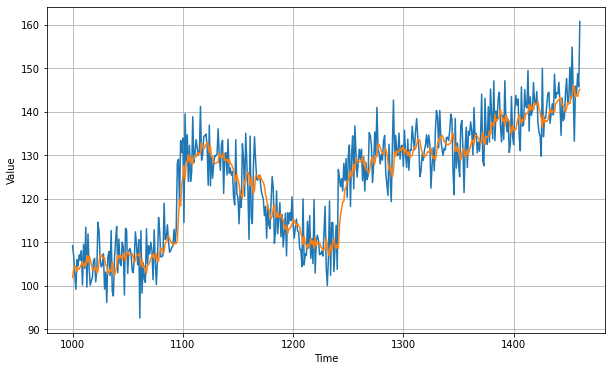

In [12]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.4636617